# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.
Tutorial followed:
https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [0]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install seaborn

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

W0514 09:15:35.634165 140515327711104 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)


Instructions for updating:
Colocations handled automatically by placer.


W0514 09:15:46.538287 140515327711104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

512

In [0]:
df=pd.read_csv("all_tweets.csv")



In [0]:
df.head()

,Unnamed: 0,filename,tweet,class
0,0,12834217_1,"As of March 13th , 2014 , the booklet had been...",1
1,1,12834217_10,Thank you in advance. : ) Download the youtube...,1
2,2,12834217_2,In order to help increase the booklets downloa...,1
3,3,12834217_3,( Simply copy and paste the following text int...,1
4,4,12834217_4,Click below for a FREE download of a colorfull...,0


In [0]:
df_test=df[['class', 'tweet']]
# df.class = df.class.astype('category')
# df_test.loc[df_train['class'] == 2, 'class'] = 1

In [0]:
df_test.columns = ["label","text"]

In [0]:
df_test.head()

,label,text
0,1,"As of March 13th , 2014 , the booklet had been..."
1,1,Thank you in advance. : ) Download the youtube...
2,1,In order to help increase the booklets downloa...
3,1,( Simply copy and paste the following text int...
4,0,Click below for a FREE download of a colorfull...


In [0]:
df_test.label = df_test.label.astype('category')


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [0]:
category_counts = len(df_test.label.cat.categories)
category_counts

2

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [0]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(category_counts, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 09:17:29.306929 140515327711104 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


In [0]:
df_train=pd.read_csv("labeled_data.csv")

In [0]:
df_train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [0]:
df_train=df_train[["class", "tweet"]]
df_train.columns=["label","text"]

In [0]:
hate=df_train[df_train.label==0]
offensive=df_train[df_train.label==1]

In [0]:
print(len(hate), len(offensive))

1430 19190


In [0]:
hate=hate.sample(frac=1)
offensive=offensive.sample(frac=1)


In [0]:
new_hate=hate[:min(len(hate), len(offensive))]
new_off=offensive[:min(len(hate), len(offensive))]


In [0]:
new_hate = new_hate.append(new_off)
df_train=new_hate

In [0]:
train_text = df_train['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(df_train.label), dtype = np.int8)

In [0]:
train_text.shape

(2860, 1)

In [0]:
train_label.shape

(2860, 2)

## Train Keras model and save weights
This only train and save our Keras layers not the embed module' weights.

In [0]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_split=0.2,
            epochs=15,
            batch_size=32)
  model.save_weights('./model.h5')

Instructions for updating:
Use tf.cast instead.


W0514 09:17:37.663952 140515327711104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 2288 samples, validate on 572 samples
Epoch 1/15
2288/2288 [==============================] - 5s 2ms/step - loss: 0.4777 - acc: 0.7614 - val_loss: 0.5720 - val_acc: 0.7587
Epoch 2/15
2288/2288 [==============================] - 2s 909us/step - loss: 0.3996 - acc: 0.8169 - val_loss: 0.7492 - val_acc: 0.6503
Epoch 3/15
2288/2288 [==============================] - 2s 919us/step - loss: 0.3844 - acc: 0.8252 - val_loss: 0.5984 - val_acc: 0.7308
Epoch 4/15
2288/2288 [==============================] - 2s 913us/step - loss: 0.3716 - acc: 0.8387 - val_loss: 0.6586 - val_acc: 0.6923
Epoch 5/15
2288/2288 [==============================] - 2s 921us/step - loss: 0.3621 - acc: 0.8352 - val_loss: 0.7815 - val_acc: 0.6276
Epoch 6/15
2288/2288 [==============================] - 2s 910us/step - loss: 0.3581 - acc: 0.8435 - val_loss: 0.5950 - val_acc: 0.7273
Epoch 7/15
2288/2288 [==============================] - 2s 917us/step - loss: 0.3379 - acc: 0.8514 - val_loss: 0.6442 - val_acc: 0.7010
Epo

## Make predictions

In [0]:
sentences=df_test.text

In [0]:
df_test.head()

,label,text
0,1,"As of March 13th , 2014 , the booklet had been..."
1,1,Thank you in advance. : ) Download the youtube...
2,1,In order to help increase the booklets downloa...
3,1,( Simply copy and paste the following text int...
4,0,Click below for a FREE download of a colorfull...


In [0]:
s=[]
labels_test=[]
for i in range(len(sentences)):
  if len(sentences[i].split())>2:
    s.append(sentences[i])
    labels_test.append(df_test.label[i])

In [0]:
test_text = s
# df_test['text'].tolist()
new_text = np.array(test_text, dtype=object)[:, np.newaxis]
# new_text=df_test.text
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fcbc0586f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [0]:
categories = df_test.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,


In [0]:
df_test.label

In [0]:
tf.confusion_matrix(labels_test, predict_labels)

Instructions for updating:
Use tf.cast instead.


W0514 09:25:44.563770 140515327711104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/confusion_matrix.py:193: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor 'confusion_matrix/SparseTensorDenseAdd:0' shape=(2, 2) dtype=int32>

In [0]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, predict_labels)

In [0]:
print(report)

              precision    recall  f1-score   support

           0       0.15      0.95      0.26      1196
           1       0.98      0.32      0.48      9288

   micro avg       0.39      0.39      0.39     10484
   macro avg       0.57      0.64      0.37     10484
weighted avg       0.89      0.39      0.46     10484



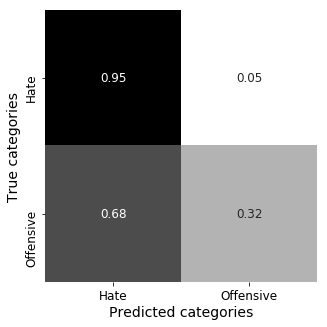

In [0]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(labels_test, predict_labels)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

##Insample predictions

In [0]:
new_text = list(df_train.text)
new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fcbc16c2358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [0]:
categories = df_test.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

In [0]:
tf.confusion_matrix(df_train.label, predict_labels)

<tf.Tensor 'confusion_matrix_1/SparseTensorDenseAdd:0' shape=(2, 2) dtype=int32>

In [0]:
from sklearn.metrics import classification_report
report = classification_report(df_train.label, predict_labels)

In [0]:
print(report)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1430
           1       0.96      0.82      0.88      1430

   micro avg       0.89      0.89      0.89      2860
   macro avg       0.90      0.89      0.89      2860
weighted avg       0.90      0.89      0.89      2860



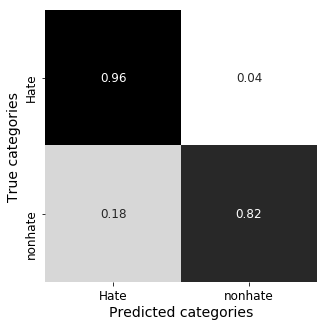

In [0]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_train.label, predict_labels)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','nonhate']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

We see that while the out of sample recall is low, the model gives high precision. Apart from that, in sample metrics are pretty good. This is probably because the model is overfitting (we can also see this from fluctuating validation accuracies in the training step). 
To tackle this we need to either increase the dataset size(make it more diverse) or reduce the complexity of the model or include droput. 
In our opinion, it would be a good idea to make the dataset more diverse by including small datasets of various types of hate, 

In [0]:
misclassified=df_train[df_train.label!=predict_labels]

In [0]:
said_nonhate=misclassified[misclassified.label==0]

In [0]:
said_hate=misclassified[misclassified.label==1]

In [0]:
#labelled as hate
list(said_hate.text)

['RT @Basedomg: im fukin yo bitch u mad as shit',
 "@whoelsebutkey you just a dark ie my nig.. It's ok..",
 "@Im_Thirst Shin's a faggot. I'm glad your chipped him.",
 "@DrMalvo \nI likes it back dare. It's free fo me cause whitey pay da fee",
 'RT @TacoPablo_: Rich dollaz always trynna snatch a bitch. Like he a bitch &#128514;',
 '@max_dashevsky u and taber the shit coon',
 'RT @KingCedd_: Hit the bitch nd forget the bitch, but i left my kids on her fuckin face',
 "Can't stand ghetto ratchet ass mofos &#128078;&#128530;",
 'Luke Bryan is such a faggot tool',
 "RT @__nijel: Niggas be out here loving ALL they hoes...that's a no no.",
 '@TomcatStraight Come over queer',
 'niggas stay with insides over some hoe shit',
 'RT @hiagokoury: Lmao what my nigga just told me &#128514;&#128514;&#128514;hoes these days... They lovin the crew gd',
 "RT @bebalizz123: Bagging thot bitches &amp; giving 'em head? Ew nigga you nasty &amp; you're better off dead.",
 'RT @willyroast2: Ratchet hoes wear flip

In [0]:
#is hate but didnt get classified as one
list(said_nonhate.text)

["RT @jezzzz_: &#8220;@Ginga_Snaps13: @jezzzz_ @ShitPussiesSay Jessica I'm not afraid to slit your throat tomorrow&#8221; @RitenourSchools @BarackObama @&#8230;",
 'RT @Fit4LifeMike: @Whitecholo23 @chanelisabeth true i need to sleep to make them Gainz bruh!! So all the hoes stay Mirin ;p \nAlright, later&#8230;',
 "@TheErniie You're a little bitch.",
 'RT @_ChickenGeorge: DEAD!!&#128128;&#8220;@TAkeme2CHINA: &#128553; RT @PEagles14: When ur fuckin and her pussy stank but u have really good friends........... ht&#8230;',
 'First thing I do when I hit the lotto is buying @moniqueeedavis two fat bitches and watching her eat both in one sitting',
 '"@jgabsss: Stacey Dash won &#128166; http://t.co/PDLG46rjOL" baddest bitch evaaaa',
 "&#8220;@TP_Three: @WestSideFlee @KekePalmer damn they got wifey &#128561;&#128561;&#128534;&#128534;&#128555;&#128553;&#128553;&#128553;&#8221;\n\nFall back nigga &#128299;.. I don't share my hoes",
 'I like taking niggas hoes but I stop doing that &#9995;',
 '

We side with the author's observations in analysis of misclassified tweets that tweets containing a lot of slurs or curse words are frequently misclassified as hate speech.
We also see that the model has difficulty picking up directed hate, for example, the nonhate tagged tweets have the subject targetted however we see that either no profanity or negative sentiment word is in use or that there are shortened spellings.
The authors had hate label misclassified 40% of the time, in our case, it is much better since it gets mislabelled on 4% of the time. However, we must keep in mind that this is training data and deep learning methods tend to overfit easily.
